# 使用 ARIMA 預測台股股價

## 載入相關套件

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf

## 載入資料集

In [2]:
START_DATE = '2020-01-01'
END_DATE = '2024-11-30'
CLOSE_FIELD_NAME = 'Close'
df = yf.download('^TWII', START_DATE, END_DATE)
df.tail(10) 

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^TWII,^TWII,^TWII,^TWII,^TWII
Date,,,,,
2024-11-18,22546.539062,22781.769531,22503.689453,22693.960938,3431100
2024-11-19,22848.800781,22906.689453,22578.750000,22614.740234,3689400
2024-11-20,22688.359375,22977.560547,22622.470703,22872.910156,3757700
2024-11-21,22555.660156,22708.570312,22490.279297,22671.660156,3395800
2024-11-22,22904.320312,23019.039062,22799.529297,22799.529297,3505100
2024-11-25,22948.369141,23172.429688,22948.369141,22996.050781,5048900
2024-11-26,22678.759766,22832.109375,22645.130859,22789.599609,2985600
2024-11-27,22334.779297,22743.990234,22334.779297,22665.580078,3577000


## 資料轉換

In [3]:
df.columns = [item[0] for item in df.columns]
df.tail(10)

,Close,High,Low,Open,Volume
Date,,,,,
2024-11-18,22546.539062,22781.769531,22503.689453,22693.960938,3431100
2024-11-19,22848.800781,22906.689453,22578.750000,22614.740234,3689400
2024-11-20,22688.359375,22977.560547,22622.470703,22872.910156,3757700
2024-11-21,22555.660156,22708.570312,22490.279297,22671.660156,3395800
2024-11-22,22904.320312,23019.039062,22799.529297,22799.529297,3505100
2024-11-25,22948.369141,23172.429688,22948.369141,22996.050781,5048900
2024-11-26,22678.759766,22832.109375,22645.130859,22789.599609,2985600
2024-11-27,22334.779297,22743.990234,22334.779297,22665.580078,3577000
2024-11-28,22298.900391,22413.250000,22124.310547,22380.449219,3123400


## 繪圖

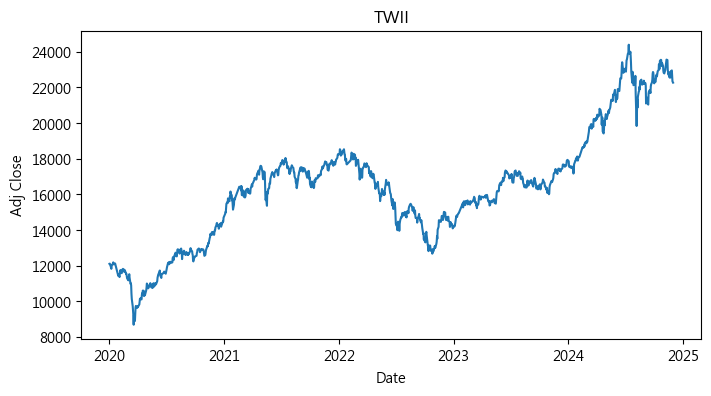

In [65]:
plt.figure(figsize=(8, 4))
sns.lineplot(x=df.index, y=CLOSE_FIELD_NAME, data=df)
plt.xlabel('Date')
plt.title('TWII');

In [66]:
df2 = df[[CLOSE_FIELD_NAME]].copy()
df2 = df2.reset_index()
dt_range = pd.date_range(start=START_DATE, end=END_DATE).to_frame(name='Date')
df2 = pd.merge(df2, dt_range, on='Date', how="right")
df2.tail(7)

,Date,Adj Close
1789,2024-11-24,NaN
1790,2024-11-25,22948.369141
1791,2024-11-26,22678.759766
1792,2024-11-27,22334.779297
1793,2024-11-28,22298.900391
1794,2024-11-29,22262.500000
1795,2024-11-30,NaN


In [67]:
df2 = df2.ffill() # 以前一天填補 missing value
df2 = df2.bfill() # 以後一天填補 missing value
df2 = df2.set_index('Date') 
df2

,Adj Close
Date,
2020-01-01,12100.480469
2020-01-02,12100.480469
2020-01-03,12110.429688
2020-01-04,12110.429688
2020-01-05,12110.429688
...,...
2024-11-26,22678.759766
2024-11-27,22334.779297
2024-11-28,22298.900391


## 穩態測試(Augmented Dickey–Fuller Test for Stationarity)

In [68]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df2[CLOSE_FIELD_NAME])
print(F'ADF統計量: {result[0]}\np value: {result[1]}' + \
      f'\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}')

ADF統計量: -0.70296711440011
p value: 0.845979490668791
滯後期數(Lags): 3
資料筆數: 1792


## 結論：p > 0.05 ==> 殘差非穩態

## ACF/PACF

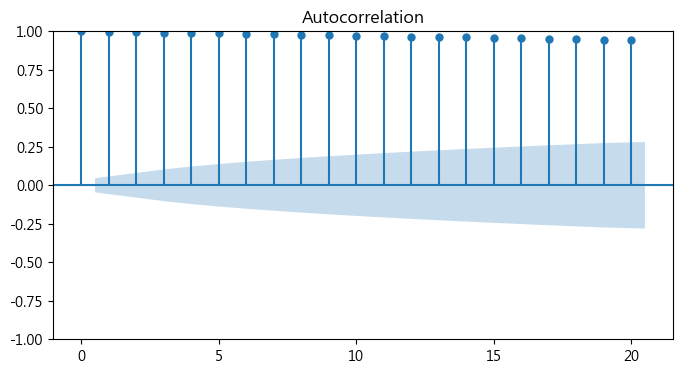

In [69]:
# ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df2[CLOSE_FIELD_NAME], lags=20)
fig.set_size_inches(8, 4)

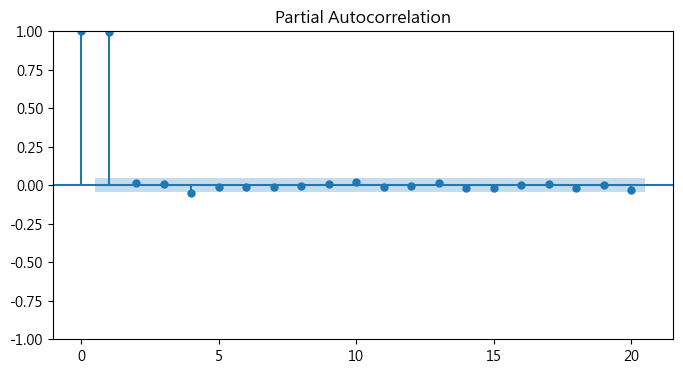

In [70]:
# PACF
fig = plot_pacf(df2[CLOSE_FIELD_NAME], lags=20, method='ywm')
fig.set_size_inches(8, 4)

## 資料分割

In [71]:
from sklearn.model_selection import train_test_split

# 資料分割
test_size=60
X_train, X_test = train_test_split(df2.values, test_size=test_size, shuffle=False)

# 查看陣列維度
X_train.shape, X_test.shape

((1736, 1), (60, 1))

## 時間序列(Time Series)模型訓練

In [72]:
from statsmodels.tsa.arima.model import ARIMA 
import statsmodels

# 參數 
P = 5
Q = 1
I = 2

df2.index = pd.DatetimeIndex(df2.index.values, freq='D')
# ar = ARIMA(X_train, order=(1, 1, MOVE_AVERAGE_PERIOD))
ar = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train, order=(P, I, Q))
model = ar.fit()

# 預測
pred = model.predict(X_train.shape[0] , X_train.shape[0] + test_size - 1, dynamic= True)
df2['pred'] = np.concatenate((model.fittedvalues, pred))

# 顯示模型訓練報告
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1736
Model:               SARIMAX(5, 2, 1)   Log Likelihood              -11218.480
Date:                Sat, 28 Dec 2024   AIC                          22450.961
Time:                        18:23:13   BIC                          22489.168
Sample:                             0   HQIC                         22465.091
                               - 1736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0379      0.015     -2.468      0.014      -0.068      -0.008
ar.L2         -0.0195      0.016     -1.184      0.236      -0.052       0.013
ar.L3          0.0939      0.015      6.144      0.0

In [73]:
model.params

array([-3.78950876e-02, -1.94834711e-02,  9.38627629e-02, -2.91854515e-02,
       -2.01986735e-02, -9.99996648e-01,  2.41841405e+04])

## 繪圖：比較實際值與預測值

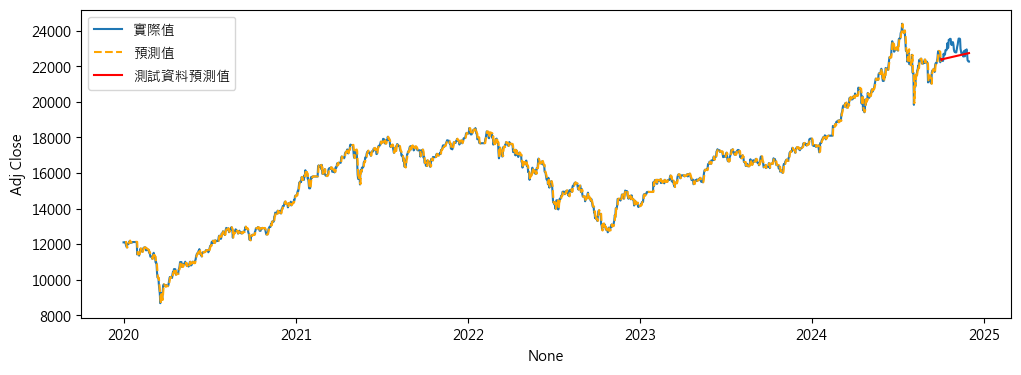

In [74]:
# 修正中文亂碼 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 4))
sns.lineplot(data=df2, x=df2.index, y=CLOSE_FIELD_NAME, label='實際值')
sns.lineplot(data=df2.iloc[5:-test_size], x=df2.index[5:-test_size], y='pred',color='orange', label='預測值', linestyle='--')
sns.lineplot(data=df2.iloc[-test_size:], x=df2.index[-test_size:], y='pred', color='red', label='測試資料預測值')
plt.legend();

In [75]:
model.resid

array([ 1.21004805e+04, -6.04759756e+03, -2.81217179e+02, ...,
       -3.67471606e+00, -5.91796142e+02,  1.38008049e+02])

In [76]:
print(f'MSE = {(np.sum(model.resid[1:]**2) / len(model.resid)-1):.2f}')

MSE = 45414.00


In [77]:
np.argmax(model.resid[5:]), np.max(model.resid[5:])

(498, 766.902546387977)

## 殘差(residual)繪圖

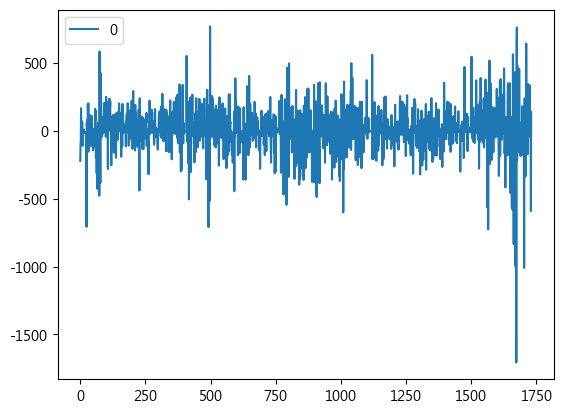

In [78]:
residuals = pd.DataFrame(model.resid[5:])
residuals.plot();

## 效應分解(Decomposition)

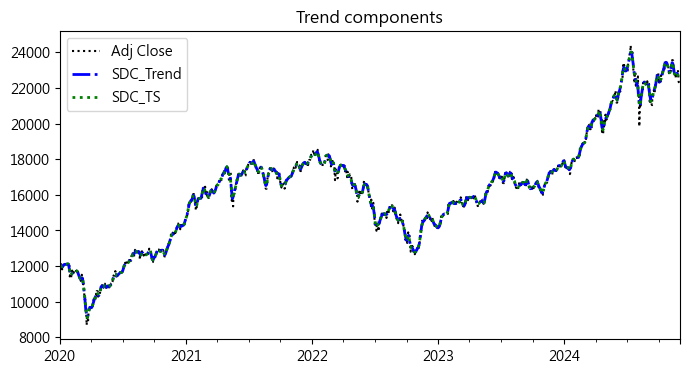

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = df[[CLOSE_FIELD_NAME]].copy()
dt_range = pd.date_range(start=START_DATE, end=END_DATE).to_frame(name='Date')
decomp = decomp.reset_index()
decomp.columns = ['Date', CLOSE_FIELD_NAME]
decomp = pd.merge(decomp, dt_range, on='Date', how="right")
decomp = decomp.ffill() # 以前一天填補 missing value
decomp = decomp.bfill() # 以後一天填補 missing value
decomp = decomp.set_index('Date')
decomp.index = pd.DatetimeIndex(decomp.index.values, freq='infer')

s_dc = seasonal_decompose(decomp, model='additive')
decomp['SDC_Seasonal'] = s_dc.seasonal
decomp['SDC_Trend'] = s_dc.trend
decomp['SDC_Error'] = s_dc.resid
decomp['SDC_TS'] = s_dc.trend + s_dc.seasonal

plt.title('Trend components')
decomp[CLOSE_FIELD_NAME].plot(figsize=(8, 4), color='black', linestyle=':', legend='Quote')
decomp['SDC_Trend'].plot(figsize=(8, 4), color='blue', linestyle='-.', lw=2, legend='SDC_Trend')
decomp['SDC_TS'].plot(figsize=(8, 4), color='green', linestyle=':', lw=2, legend='TS');

## 參數調校(Tuning)

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [98]:
I = 2
MIN_MSE = 9999999999
MIN_P, MIN_Q = 0, 0
for P in (1, 3, 5, 7, 9, 11):
    for Q in (1, 10, 20, 30):
        ar = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train, order=(P, I, Q))
        model = ar.fit()
        
        # 預測
        pred = model.predict(X_train.shape[0] , X_train.shape[0] + test_size - 1, dynamic= True)
        df2['pred'] = np.concatenate((model.fittedvalues, pred))
        df2['resid']= df2[CLOSE_FIELD_NAME] - df2['pred']
        mse = (np.sum(df2['resid'][1:]**2) / len(df2['resid'])-1)
        print(f'P:{P}, Q:{Q}, MSE = {mse:.2f}')
        if mse < MIN_MSE:
            MIN_P, MIN_Q, MIN_MSE = P, Q, mse
print(f'最佳參數組合 P:{MIN_P}, Q:{MIN_Q}, MSE = {MIN_MSE:.2f}')

P:1, Q:1, MSE = 53561.51
P:1, Q:10, MSE = 54008.59
P:1, Q:20, MSE = 54047.46
P:1, Q:30, MSE = 53060.35
P:3, Q:1, MSE = 54534.78
P:3, Q:10, MSE = 53612.89
P:3, Q:20, MSE = 53639.36
P:3, Q:30, MSE = 54549.71
P:5, Q:1, MSE = 53857.12
P:5, Q:10, MSE = 53816.61
P:5, Q:20, MSE = 53253.39
P:5, Q:30, MSE = 53680.95
P:7, Q:1, MSE = 53944.25
P:7, Q:10, MSE = 53970.59
P:7, Q:20, MSE = 54122.24
P:7, Q:30, MSE = 54458.10
P:9, Q:1, MSE = 53916.87
P:9, Q:10, MSE = 53315.65
P:9, Q:20, MSE = 52797.18
P:9, Q:30, MSE = 51822.44
P:11, Q:1, MSE = 53880.49
P:11, Q:10, MSE = 52992.68
P:11, Q:20, MSE = 53222.61
P:11, Q:30, MSE = 53151.21
最佳參數組合 P:9, Q:30, MSE = 51822.44


## 只計算測試資料的MSE

In [99]:
I = 2
MIN_MSE = 9999999999
MIN_P, MIN_Q = 0, 0
for P in (1, 3, 5, 7, 9, 11):
    for Q in (1, 10, 20, 30):
        ar = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train, order=(P, I, Q))
        model = ar.fit()
        
        # 預測
        pred = model.predict(X_train.shape[0] , X_train.shape[0] + test_size - 1, dynamic= True)
        resid= X_test.reshape(-1) - pred
        # if P == 1 and Q == 1:
        #     print(resid.shape)
        #     print(resid)
        mse = (np.sum(resid**2) / len(resid))
        print(f'P:{P}, Q:{Q}, MSE = {mse:.2f}')
        if mse < MIN_MSE:
            MIN_P, MIN_Q, MIN_MSE = P, Q, mse
print(f'最佳參數組合 P:{MIN_P}, Q:{MIN_Q}, MSE = {MIN_MSE:.2f}')

P:1, Q:1, MSE = 282260.41
P:1, Q:10, MSE = 303266.78
P:1, Q:20, MSE = 307069.02
P:1, Q:30, MSE = 283613.06
P:3, Q:1, MSE = 317564.65
P:3, Q:10, MSE = 293485.94
P:3, Q:20, MSE = 295231.29
P:3, Q:30, MSE = 328314.64
P:5, Q:1, MSE = 298145.71
P:5, Q:10, MSE = 303497.43
P:5, Q:20, MSE = 286246.62
P:5, Q:30, MSE = 303526.64
P:7, Q:1, MSE = 300864.05
P:7, Q:10, MSE = 304389.79
P:7, Q:20, MSE = 315659.31
P:7, Q:30, MSE = 326703.20
P:9, Q:1, MSE = 300069.08
P:9, Q:10, MSE = 283863.83
P:9, Q:20, MSE = 274395.30
P:9, Q:30, MSE = 247581.19
P:11, Q:1, MSE = 299257.68
P:11, Q:10, MSE = 275807.88
P:11, Q:20, MSE = 285963.60
P:11, Q:30, MSE = 287849.90
最佳參數組合 P:9, Q:30, MSE = 247581.19


In [101]:
RMSE = MIN_MSE ** 0.5
RMSE

497.5753074937175